# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2023-07-04 15:19:04--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  16.4MB/s    in 13s     

2023-07-04 15:19:17 (12.9 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2023-07-04 15:19:17--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  17.0MB/s    in 3.6s    

2023-07-04 15:19:21 (17.0 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2023-07-04 15:19:21--
Total wall clock time: 18s
Downloaded: 2 files, 235M in

In [ ]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [ ]:
# First, lets load the dataset
data_train = dset.SVHN('./',
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs):
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode

        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))

    return loss_history, train_history, val_history

def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader

    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs_on_gpu = inputs.to(device)
            labels_on_gpu = labels.to(device)
            outputs = model(inputs_on_gpu)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels_on_gpu).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, interpolation=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./',
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                           sampler=train_sampler)

Визуализируем результаты аугментации (вообще, смотреть на сгенерированные данные всегда очень полезно).



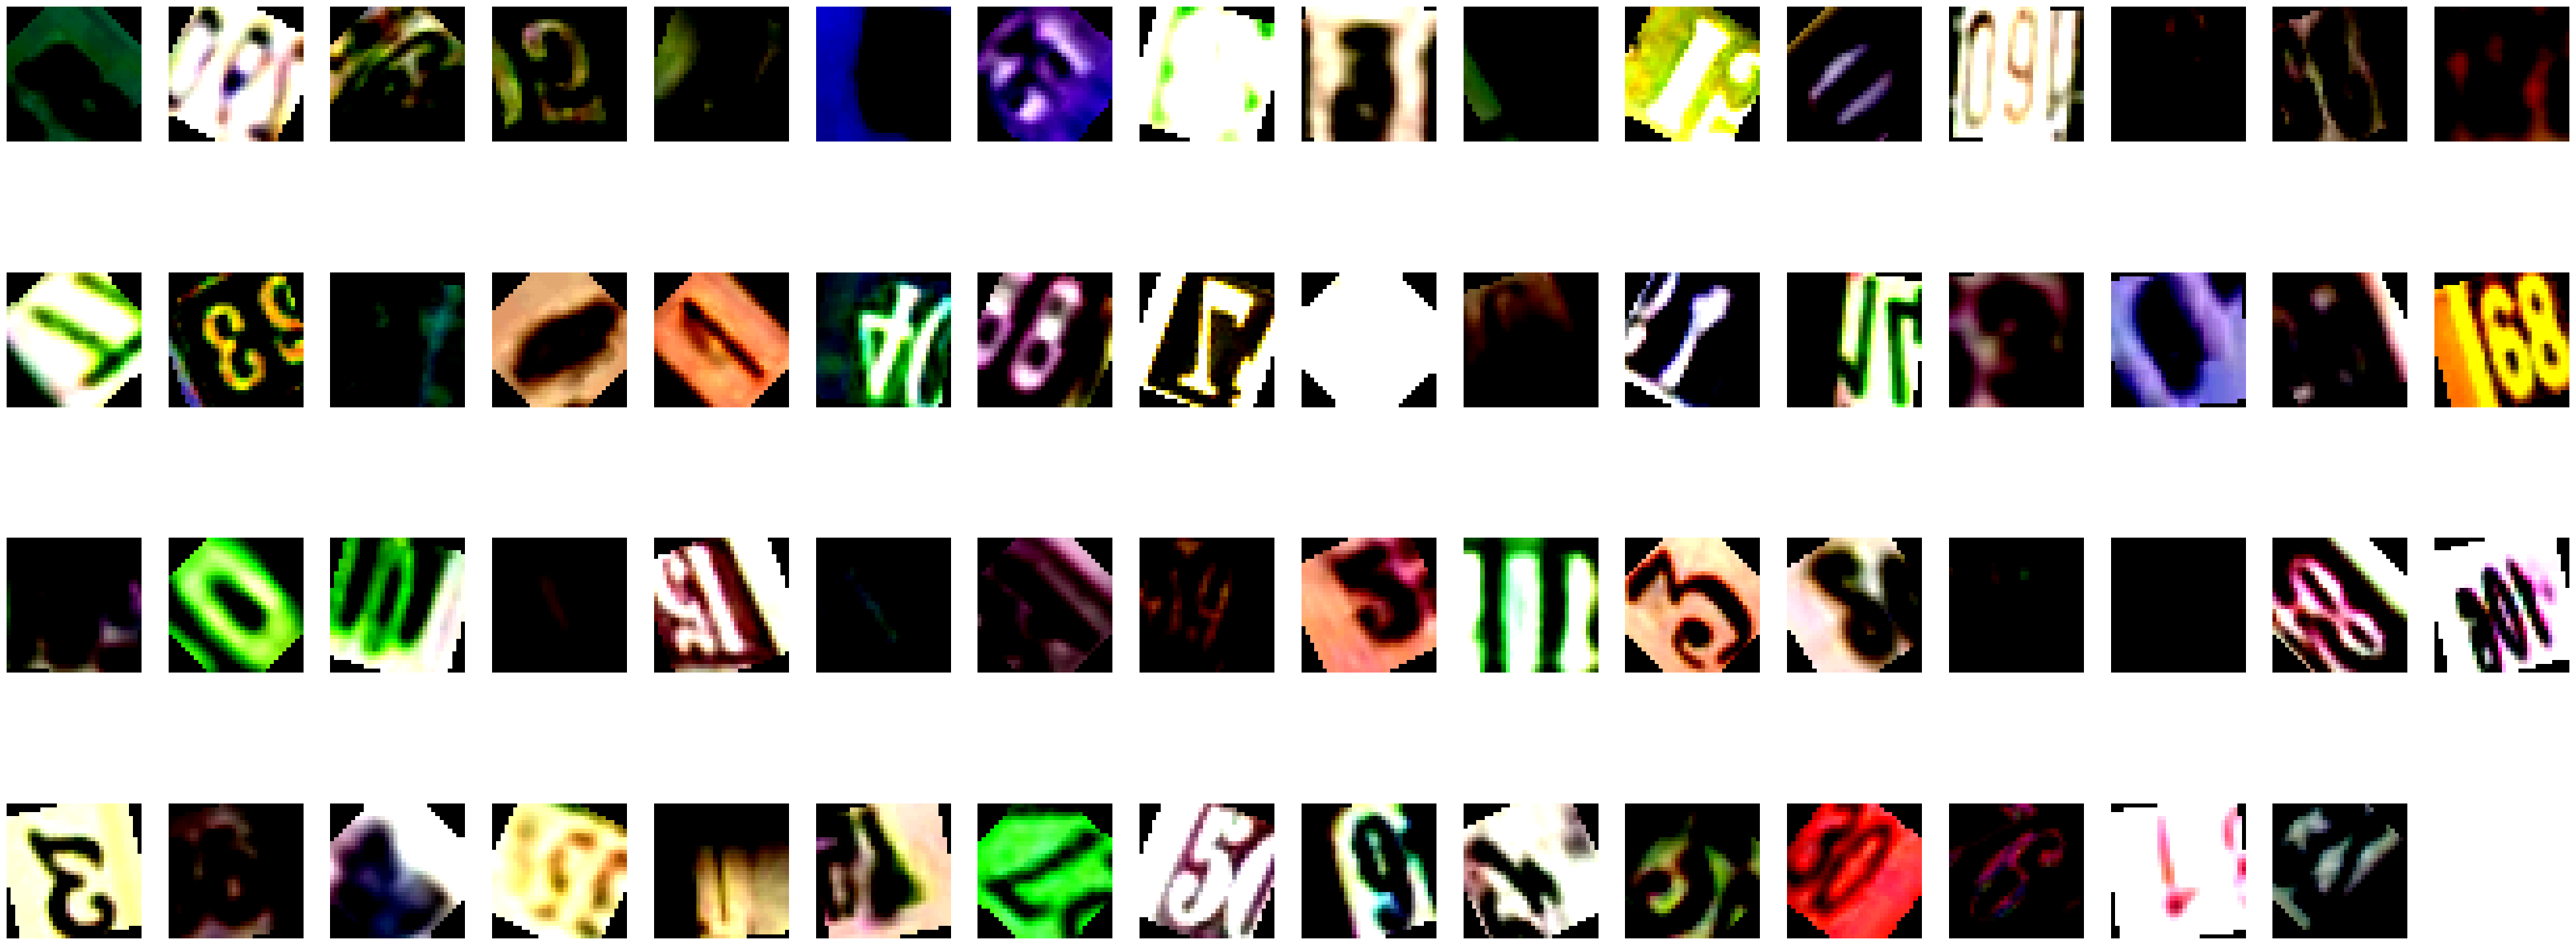

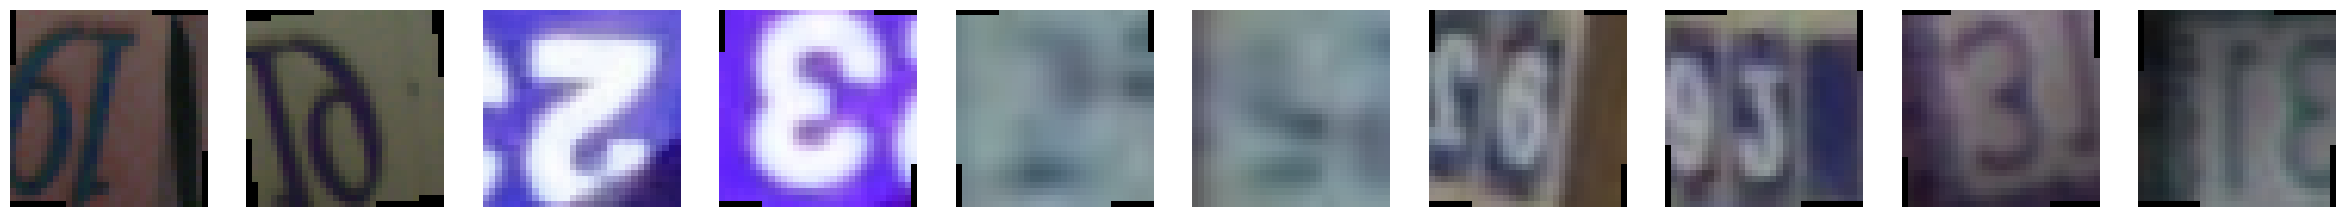

In [ ]:
# Get a batch of augmented images
for images, _ in train_aug_loader:
    # Visualize the augmented images
    fig = plt.figure(figsize=(50, 20))
    for idx in range(images.shape[0]):
        img = torch.clamp(images[idx].permute(1, 2, 0), 0, 1)
        ax = fig.add_subplot(4, 16, max(1, idx))
        ax.imshow(img, vmin=0, vmax=1)
        ax.axis('off')
    plt.show()
    break

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, interpolation=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./',
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли аугментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

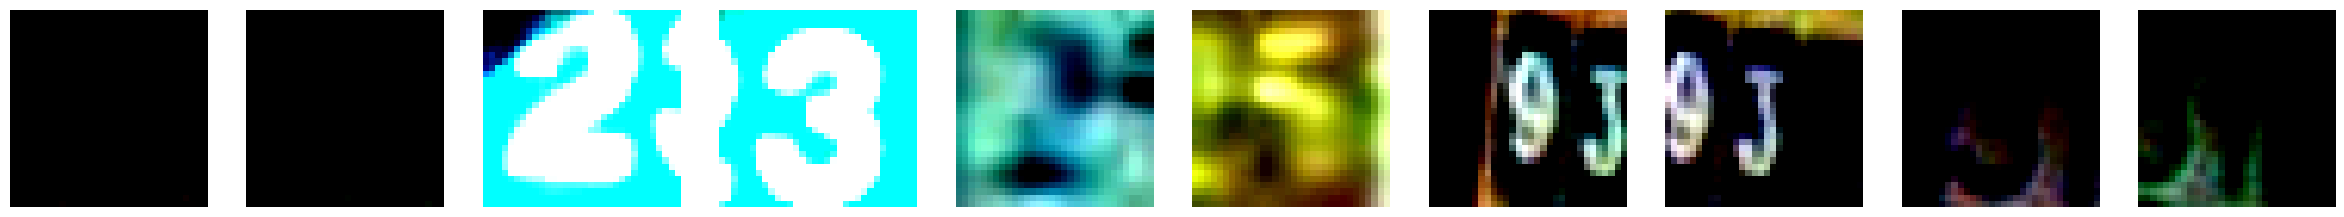

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomInvert(0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20]),
])
data_aug_train = dset.SVHN('./',
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size,
                                           sampler=train_sampler)
plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_train):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(torch.clamp(x.permute(1, 2, 0), 0, 1))
    plt.axis('off')

In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.543943, Train accuracy: 0.836621, Val accuracy: 0.844720
Average loss: 0.520821, Train accuracy: 0.846296, Val accuracy: 0.843287
Average loss: 0.504304, Train accuracy: 0.849555, Val accuracy: 0.858235
Average loss: 0.497855, Train accuracy: 0.852831, Val accuracy: 0.843492
Average loss: 0.487827, Train accuracy: 0.855629, Val accuracy: 0.854549


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flattener(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10)
)

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.319517, Train accuracy: 0.554141, Val accuracy: 0.752713
Average loss: 0.534067, Train accuracy: 0.841296, Val accuracy: 0.847246
Average loss: 0.442445, Train accuracy: 0.868085, Val accuracy: 0.874821
Average loss: 0.392306, Train accuracy: 0.882486, Val accuracy: 0.888131
Average loss: 0.361409, Train accuracy: 0.894158, Val accuracy: 0.880827
Average loss: 0.336624, Train accuracy: 0.899891, Val accuracy: 0.896867
Average loss: 0.315527, Train accuracy: 0.906699, Val accuracy: 0.894069
Average loss: 0.300032, Train accuracy: 0.910811, Val accuracy: 0.893181
Average loss: 0.289024, Train accuracy: 0.913575, Val accuracy: 0.902191
Average loss: 0.275080, Train accuracy: 0.917500, Val accuracy: 0.905808


In [ ]:
torch.save(lenet_model, f'saved_models/lenet_model.pt')

In [ ]:
import random
import math

In [ ]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, step_size):
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):

            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()

            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]

            loss_accum += loss_value
        scheduler.step()
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)

        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)

        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        if math.isnan(ave_loss):
            raise Exception("something went wrong")

    return loss_history, train_history, val_history

In [ ]:
import itertools
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well
new_lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    Flattener(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(inplace=True),
    nn.Linear(120, 84),
    nn.ReLU(inplace=True),
    nn.Linear(84, 10)
)
new_lenet_model.type(torch.cuda.FloatTensor)
new_lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
reg = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {}

random_runs = 10

for _ in range(random_runs):
    lr = random.choice(learning_rates)
    anneal_epoch = random.choice(anneal_epochs)
    reg_value = random.choice(reg)
    hyperparams = Hyperparams(learning_rate=lr, anneal_epochs=anneal_epoch, reg=reg_value)
    print(hyperparams)
    optimizer = optim.SGD(new_lenet_model.parameters(), lr=lr, weight_decay=reg_value)
    try:
        _, train_history, val_history = train_model(new_lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, anneal_epoch)
        run_result = RunResult(new_lenet_model, train_history, val_history, val_history[-1])
        run_record[hyperparams] = run_result
    except:
      continue

Hyperparams(learning_rate=0.0001, anneal_epochs=15, reg=1e-05)
Average loss: 2.300755, Train accuracy: 0.101423, Val accuracy: 0.103133
Average loss: 2.298481, Train accuracy: 0.101423, Val accuracy: 0.103133
Hyperparams(learning_rate=0.001, anneal_epochs=20, reg=1e-07)
Average loss: 2.283910, Train accuracy: 0.121779, Val accuracy: 0.162378
Average loss: 2.262833, Train accuracy: 0.186158, Val accuracy: 0.189270
Average loss: 2.249066, Train accuracy: 0.189264, Val accuracy: 0.188997
Average loss: 2.242838, Train accuracy: 0.189264, Val accuracy: 0.188997
Average loss: 2.239715, Train accuracy: 0.189264, Val accuracy: 0.188997
Average loss: 2.238100, Train accuracy: 0.189264, Val accuracy: 0.188997
Hyperparams(learning_rate=0.1, anneal_epochs=1, reg=0.001)
Average loss: 1.115134, Train accuracy: 0.634235, Val accuracy: 0.824312
Average loss: 0.479385, Train accuracy: 0.859042, Val accuracy: 0.870248
Average loss: 0.398855, Train accuracy: 0.883067, Val accuracy: 0.885673
Average loss:

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result

print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))

Best validation accuracy: 0.90, best hyperparams: Hyperparams(learning_rate=0.0001, anneal_epochs=1, reg=0.001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
best_model = nn.Sequential(
    nn.Conv2d(3, 32, 3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.Conv2d(32, 64, 3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.Conv2d(64, 128, 5, stride=2),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, 5, stride=2, padding=2),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.Conv2d(128, 128, 5, stride=2, padding=2),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    Flattener(),
    nn.Linear(512, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 10)
)

# for module in best_model.parameters():
#     if isinstance(module, (nn.Conv2d, nn.Linear)):
#         nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.Adam(best_model.parameters(), lr=best_hyperparams.learning_rate, weight_decay=best_hyperparams.reg)
loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 20, best_hyperparams.anneal_epochs)

Average loss: 1.044649, Train accuracy: 0.719602, Val accuracy: 0.865197
Average loss: 0.477040, Train accuracy: 0.877692, Val accuracy: 0.892021
Average loss: 0.366433, Train accuracy: 0.906921, Val accuracy: 0.899939
Average loss: 0.314712, Train accuracy: 0.921919, Val accuracy: 0.907105
Average loss: 0.289355, Train accuracy: 0.928267, Val accuracy: 0.908402
Average loss: 0.273430, Train accuracy: 0.934495, Val accuracy: 0.909562
Average loss: 0.268440, Train accuracy: 0.936150, Val accuracy: 0.910177
Average loss: 0.264576, Train accuracy: 0.937088, Val accuracy: 0.910109
Average loss: 0.263117, Train accuracy: 0.936696, Val accuracy: 0.909358
Average loss: 0.262846, Train accuracy: 0.936832, Val accuracy: 0.910313
Average loss: 0.260159, Train accuracy: 0.938334, Val accuracy: 0.910382
Average loss: 0.260155, Train accuracy: 0.937822, Val accuracy: 0.911542
Average loss: 0.260307, Train accuracy: 0.938061, Val accuracy: 0.910996
Average loss: 0.260537, Train accuracy: 0.937907, V

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9033497234173326


# j4f

In [ ]:
old_lenet_model = torch.load(f'saved_models/lenet_model.pt')

In [ ]:
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size)
old_lenet_model_test_accuracy = compute_accuracy(old_lenet_model, test_loader)
print("Final test accuracy - ", old_lenet_model_test_accuracy)

Final test accuracy -  0.8955516287645974


In [ ]:
torch.save(best_model, f'saved_models/best_model.pt')